In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
newDf = pd.read_csv(,low_memory=False) # LOAD YOUR DATA HERE

In [ ]:
newDf = newDf.iloc[:, 1:]
newDf.rename(columns={'Unnamed: 0': 'EQID'}, inplace=True) # THIS PREPROCESSIG IS CUSTOM TO THE AVAILABLE DATA AND FEW PARTS CAN BE SKIPPED
newDf.head(1)

In [ ]:
# PREPROCESSING ALL THE RECORDS INTO FLLOATS FOR PRECISION REPRESENTATION
newDf = newDf.apply(pd.to_numeric, errors='coerce')
newDf = newDf.astype(float)

In [ ]:
newDf # DATA IN PRECISE FLOATING POINTS

In [ ]:
newDf.columns # THE ORDER OF COLUMNS IN THE CURRENT DATA

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = newDf[['PGA','PGD','Fp','Tsig','Ia','CAV','vs30','dir']]  #Sc is just named vs30 here... change if required
column_names = X.columns
X = X[column_names].values
y = newDf[['EQID','0.01', '0.015', '0.02', '0.03', '0.04', '0.05', '0.06', '0.075',
       '0.09', '0.1', '0.15', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.75',
       '0.8', '0.9', '1', '1.2', '1.5', '2', '2.5', '3', '4']]
column_names = y.columns
y = y[column_names].values

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test= train_test_split(X_normalized, y ,test_size=0.2, random_state=42)
y_train = np.log(Y_train[:, 1:])
y_test = np.log(Y_test[:, 1:])

In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.losses import mse
from keras.optimizers import Adam
import tensorflow as tf
# Define encoder model
def create_encoder(input_dim, latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3):
    input_layer = Input(shape=(input_dim,))
    x = Dense(intermediate_dim, activation='relu')(input_layer)
    """
    CUSTOMIZE ADDITIONAL LAYERS AS REQUIRED
    """
    x = Dense(intermediate_dim_3, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    return Model(input_layer, [z_mean, z_log_var])

# Define decoder model
def create_decoder(latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3, input_dim):
    latent_inputs = Input(shape=(latent_dim,))
    decoder_h = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
    """
    CUSTOMIZE ADDITIONAL LAYERS AS REQUIRED
    """
    decoder_mean = Dense(input_dim, name='decoder_output')(decoder_h)
    decoder_output = decoder_mean
    return Model(latent_inputs, decoder_output)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE architecture
def create_vae(input_dim, latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3):
    encoder = create_encoder(input_dim, latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3)
    decoder = create_decoder(latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3, input_dim)

    input_layer = Input(shape=(input_dim,))
    z_mean, z_log_var = encoder(input_layer)
    z = Lambda(sampling)([z_mean, z_log_var])
    output_layer = decoder(z)

    vae = Model(input_layer, output_layer)

    reconstruction_loss = mse(K.flatten(input_layer), K.flatten(output_layer))
    kl_loss = (-5e-5)*K.mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae, encoder, decoder

# Example usage:
input_dim = y_train.shape[1]  # Dimension of input and output
latent_dim = 3  # Dimension of latent space
intermediate_dim = 16  # Dimension of intermediate layers
intermediate_dim_1 = 12
intermediate_dim_2 = 8
intermediate_dim_3 = 4

vae, encoder, decoder = create_vae(input_dim, latent_dim, intermediate_dim,intermediate_dim_1,intermediate_dim_2,intermediate_dim_3)
optimizer = Adam(lr=0.0002)
vae.compile(optimizer=optimizer, metrics=['R2Score', 'mse'])
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 27)]                 0         []                            
                                                                                                  
 model (Functional)          [(None, 3),                  822       ['input_3[0][0]']             
                              (None, 3)]                                                          
                                                                                                  
 lambda (Lambda)             (None, 3)                    0         ['model[0][0]',               
                                                                     'model[0][1]']               
                                                                                            

In [ ]:

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Define the checkpoint file path
checkpoint_path = # CREATE A CHECKPOINT PATH TO SAVE YOUR TRAINED MODEL

# Create a ModelCheckpoint callback to save the best model
ckpt_callback = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=False,  # Save entire model, not just weights
                                verbose=1)

# Train the model using the custom loss function
history = vae.fit(y_train, y_train, batch_size=16, epochs=50, validation_split=0.25, callbacks=[ckpt_callback], verbose=1)

# Load the best model from the checkpoint file
best_model = load_model(checkpoint_path)

Epoch 1/50
50/52 [===========================>..] - ETA: 0s - loss: 71.4846 - r2_score: -29.0442 - mse: 71.4142
Epoch 1: val_loss improved from inf to 28.36417, saving model to /content/drive/MyDrive/SDA Codes/CVAE_final/final_model/best_model_cvae.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 5s 25ms/step - loss: 69.9883 - r2_score: -28.7267 - mse: 69.9600 - val_loss: 28.3642 - val_r2_score: -11.5005 - val_mse: 28.1947
Epoch 2/50
49/52 [===========================>..] - ETA: 0s - loss: 26.8564 - r2_score: -10.3955 - mse: 26.8545
Epoch 2: val_loss improved from 28.36417 to 23.22131, saving model to /content/drive/MyDrive/SDA Codes/CVAE_final/final_model/best_model_cvae.h5
52/52 [==============================] - 0s 8ms/step - loss: 26.8596 - r2_score: -10.3143 - mse: 26.8551 - val_loss: 23.2213 - val_r2_score: -9.2214 - val_mse: 23.0747
Epoch 3/50
47/52 [==========================>...] - ETA: 0s - loss: 15.8654 - r2_score: -5.6299 - mse: 15.8638
Epoch 3: val_loss improved from 23.22131 to 6.81843, saving model to /content/drive/MyDrive/SDA Codes/CVAE_final/final_model/best_model_cvae.h5
52/52 [==============================] - 0s 8ms/step - loss: 15.1231 - r2_score: -5.3780 - mse: 15.1303 - val_loss: 6.8184 - val_r2_score: -2.0451 - v

In [ ]:
# encoder.save('/content/drive/MyDrive/SDA Codes/CVAE_final/final_model/encoder_model.h5')
# decoder.save('/content/drive/MyDrive/SDA Codes/CVAE_final/final_model/decoder_model.h5')
# save the models if interested to look at encoder and decoder seperately

# Mapping layers

In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


def build_model():
    model = Sequential()
    model.add(Dense(8, input_shape=(8,), activation='relu', kernel_initializer='he_uniform'))  # He uniform initializer
    model.add(Dense(4, activation='relu', kernel_initializer='he_uniform'))  # He uniform initializer
    model.add(Dense(3, activation='linear'))  # Linear activation for regression
    optimizer = Adam(learning_rate=0.002)  # Example learning rate, adjust as necessary
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])  # Adjust loss and metrics based on your problem
    return model


# Compile the model using the custom R2Score metric
model = build_model()
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse', 'mape', 'R2Score'])

# Define the checkpoint path
checkpoint_path = 'ADD YOUR PATH'

# Custom Callback to save best model based on R2Score
class SaveBestR2ScoreModel(Callback):
    def __init__(self, filepath, monitor='val_r2_score', mode='max', save_weights_only=False, save_best_only=True):
        super(SaveBestR2ScoreModel, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_weights_only = save_weights_only
        self.save_best_only = save_best_only
        self.best_score = -np.Inf if self.mode == 'max' else np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_score = logs.get(self.monitor)
        if current_score is None:
            return

        if (self.mode == 'max' and current_score > self.best_score) or \
           (self.mode == 'min' and current_score < self.best_score):

            self.best_score = current_score
            if self.save_best_only:
                if self.save_weights_only:
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    self.model.save(self.filepath, overwrite=True)
                print(f"Epoch {epoch+1}: Best model saved with {self.monitor} = {current_score:.4f}")

# Create a callback instance
ckpt_callback = SaveBestR2ScoreModel(filepath=checkpoint_path,
                                     monitor='r2_score',  # Adjust to match the name of your custom metric
                                     mode='max',         # Adjust based on whether higher or lower is better
                                     save_weights_only=False,
                                     save_best_only=True)

# Train the model using the custom R2Score metric
history = model.fit(X_train, encoded_data_train, batch_size=64, epochs=600, validation_split=0.25, callbacks=[ckpt_callback], verbose=1)

# Load the best model from the checkpoint file
best_model = load_model(checkpoint_path)
best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse', 'mape'])


Epoch 1/600
13/13 [==============================] - 3s 69ms/step - loss: 64.5124 - mae: 7.6304 - mse: 64.5124 - mape: 109.7360 - r2_score: -10.0231 - val_loss: 60.2285 - val_mae: 7.3795 - val_mse: 60.2285 - val_mape: 98.9262 - val_r2_score: -9.8576
Epoch 2/600
13/13 [==============================] - 0s 11ms/step - loss: 60.3535 - mae: 7.3644 - mse: 60.3535 - mape: 113.2267 - r2_score: -9.3356 - val_loss: 56.1140 - val_mae: 7.1044 - val_mse: 56.1140 - val_mape: 95.0509 - val_r2_score: -9.1399
Epoch 3/600
13/13 [==============================] - 0s 11ms/step - loss: 56.2464 - mae: 7.0851 - mse: 56.2464 - mape: 116.6365 - r2_score: -8.6624 - val_loss: 52.1007 - val_mae: 6.8224 - val_mse: 52.1007 - val_mape: 91.4584 - val_r2_score: -8.4441
Epoch 4/600
13/13 [==============================] - 0s 11ms/step - loss: 52.0772 - mae: 6.7909 - mse: 52.0772 - mape: 124.0637 - r2_score: -7.9791 - val_loss: 48.1219 - val_mae: 6.5225 - val_mse: 48.1219 - val_mape: 87.7626 - val_r2_score: -7.7550
Epo

In [ ]:
predictions = best_model.predict(X_test)

9/9 [==============================] - 0s 4ms/step


In [ ]:
decoded_data_test = decoder.predict(predictions)
print("Decoded", decoded_data_test)

9/9 [==============================] - 0s 5ms/step
Decoded [[-5.6380725 -5.5751505 -5.5337224 ... -6.0866036 -6.1342025 -6.1989894]
 [-6.1670833 -6.1120553 -6.0599713 ... -6.6550875 -6.7100296 -6.777949 ]
 [-3.1575491 -3.062522  -3.068436  ... -3.4305024 -3.4486728 -3.4934216]
 ...
 [-6.356756  -6.307767  -6.2501216 ... -6.865058  -6.925834  -6.991487 ]
 [-6.035442  -5.976968  -5.9283423 ... -6.510789  -6.56243   -6.6311283]
 [-5.4079413 -5.3427505 -5.305337  ... -5.8415613 -5.887157  -5.9493065]]


In [ ]:
pd.DataFrame(Y_test).iloc[:,0]

0      650.0
1      209.0
2       23.0
3      679.0
4      804.0
       ...  
273    182.0
274    340.0
275     80.0
276    455.0
277    383.0
Name: 0, Length: 278, dtype: float64

In [ ]:
print(type(Y_test))
print(type(decoded_data_test))
Y_test_df = pd.DataFrame(Y_test)
second_column_Y_test = Y_test_df.iloc[:, 0]
decoded_data_test = pd.DataFrame(decoded_data_test)
decoded_data_test.insert(0, 'EQID', second_column_Y_test.values)
decoded_data_test.head(1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


EQID         0        1         2         3         4         5         6  \
0  650.0 -5.638072 -5.57515 -5.533722 -5.462239 -5.441071 -5.412098 -5.407156   

          7        8  ...        17        18        19        20        21  \
0 -5.396555 -5.41132  ... -5.798469 -5.821006 -5.820306 -5.867208 -5.935142   

         22        23        24        25        26  
0 -5.992313 -6.030964 -6.086604 -6.134202 -6.198989  

[1 rows x 28 columns]

In [ ]:
Y_test_df.head(1)

0        1        2         3         4         5         6         7   \
0  650.0  0.00124  0.00122  0.001409  0.001518  0.001622  0.001735  0.001967   

         8         9   ...        18        19        20        21        22  \
0  0.001879  0.001647  ...  0.000862  0.000816  0.000809  0.000888  0.000752   

         23        24       25        26        27  
0  0.000639  0.000572  0.00062  0.000667  0.000746  

[1 rows x 28 columns]

In [ ]:
y_test_df = np.log(Y_test[:, 1:])
y_test_df = pd.DataFrame(y_test_df)
second_column_Y_test = Y_test_df.iloc[:, 0]
y_test_df.insert(0, 'EQID', second_column_Y_test.values)
y_test_df

EQID         0         1         2         3         4         5  \
0    650.0 -6.692669 -6.708808 -6.564602 -6.490242 -6.424133 -6.356976   
1    209.0 -6.161767 -6.009610 -6.073234 -5.836842 -5.910464 -5.819113   
2     23.0 -3.272455 -3.281796 -3.306480 -3.203395 -3.339847 -3.192004   
3    679.0 -4.644717 -4.419686 -4.394326 -4.428857 -4.305880 -4.019904   
4    804.0 -3.223414 -3.231286 -3.233894 -3.212930 -3.196440 -3.216475   
..     ...       ...       ...       ...       ...       ...       ...   
273  182.0 -6.151480 -6.043523 -5.914702 -5.927662 -5.797627 -5.579550   
274  340.0 -2.155220 -2.146308 -2.093907 -1.968505 -1.838882 -1.726340   
275   80.0 -6.413698 -6.450575 -6.220982 -6.168849 -5.963191 -6.134739   
276  455.0 -7.994835 -8.005733 -8.003377 -8.021206 -7.980193 -8.104639   
277  383.0 -3.510779 -3.507321 -3.551466 -3.367393 -3.174979 -3.151794   

            6         7         8  ...        17        18        19  \
0   -6.231053 -6.276958 -6.408745  ... -7.056052 -7.110713 -7.119455   
1   -5.839053 -5.876370 -5.674141  ... -6.394544 -6.414354 -6.482083   
2   -3.158581 -3.272425 -3.228723  ... -3.368106 -3.387290 -3.497616   
3   -4.199343 -3.991034 -4.242973  ... -4.735224 -4.729510 -4.731015   
4   -3.166757 -2.944440 -3.033859  ... -3.111259 -2.910421 -2.827903   
..        ...       ...       ...  ...       ...       ...       ...   
273 -5.916018 -6.093711 -6.119609  ... -6.641581 -6.636415 -6.644723   
274 -1.767812 -1.646781 -1.597309  ... -1.938682 -2.128893 -2.149562   
275 -6.026426 -6.200111 -6.429993  ... -6.662975 -6.737389 -6.759455   
276 -8.352214 -8.423821 -8.395288  ... -8.805389 -8.812920 -8.821014   
277 -3.333375 -3.125804 -3.067618  ... -3.483169 -3.724542 -3.952625   

           20        21        22        23        24        25        26  
0   -7.026960 -7.192965 -7.355065 -7.466548 -7.385819 -7.312149 -7.200806  
1   -6.538620 -6.595224 -6.562822 -6.510425 -6.532326 -6.581362 -6.695379  
2   -3.717344 -4.097374 -3.880087 -4.119768 -4.102740 -4.157222 -4.203558  
3   -4.753212 -4.802330 -4.837765 -4.818007 -4.727359 -4.627521 -4.770933  
4   -3.001717 -3.125273 -3.167271 -3.176706 -3.302284 -3.508129 -3.570861  
..        ...       ...       ...       ...       ...       ...       ...  
273 -6.663261 -6.712646 -6.740239 -6.714317 -6.735684 -6.756015 -6.805681  
274 -2.207083 -2.222780 -2.242986 -2.317281 -2.410789 -2.367897 -2.491945  
275 -6.615484 -6.552801 -6.578709 -6.554215 -6.562372 -6.826071 -7.088937  
276 -8.815247 -8.813352 -8.821573 -8.867485 -8.890969 -8.887627 -8.901814  
277 -3.824075 -3.942417 -3.851478 -3.729565 -3.855763 -3.844677 -3.869861  

[278 rows x 28 columns]

In [ ]:
decoded_data_test

EQID         0         1         2         3         4         5  \
0    650.0 -5.638072 -5.575150 -5.533722 -5.462239 -5.441071 -5.412098   
1    209.0 -6.167083 -6.112055 -6.059971 -5.984698 -5.956640 -5.930439   
2     23.0 -3.157549 -3.062522 -3.068436 -3.042331 -3.032176 -2.983463   
3    679.0 -5.375092 -5.308733 -5.272346 -5.205544 -5.185642 -5.154602   
4    804.0 -4.770948 -4.693716 -4.670516 -4.597952 -4.593687 -4.561905   
..     ...       ...       ...       ...       ...       ...       ...   
273  182.0 -6.086667 -6.032734 -5.981029 -5.919001 -5.882226 -5.852536   
274  340.0 -1.534417 -1.421410 -1.453369 -1.423063 -1.470467 -1.417590   
275   80.0 -6.356756 -6.307767 -6.250122 -6.191138 -6.147012 -6.117537   
276  455.0 -6.035442 -5.976968 -5.928342 -5.845886 -5.825802 -5.800872   
277  383.0 -5.407941 -5.342751 -5.305337 -5.242074 -5.218834 -5.187047   

            6         7         8  ...        17        18        19  \
0   -5.407156 -5.396555 -5.411320  ... -5.798469 -5.821006 -5.820306   
1   -5.915346 -5.901957 -5.944157  ... -6.349518 -6.375164 -6.355478   
2   -3.036710 -3.022794 -2.920460  ... -3.221530 -3.228779 -3.330124   
3   -5.155790 -5.144901 -5.147202  ... -5.525226 -5.546144 -5.556198   
4   -4.570893 -4.569085 -4.535866  ... -4.893334 -4.910951 -4.937891   
..        ...       ...       ...  ...       ...       ...       ...   
273 -5.843796 -5.823371 -5.866678  ... -6.268960 -6.293816 -6.283014   
274 -1.478691 -1.474792 -1.290595  ... -1.527380 -1.523325 -1.670710   
275 -6.105491 -6.080728 -6.140110  ... -6.551572 -6.577889 -6.559760   
276 -5.785233 -5.777307 -5.809301  ... -6.210326 -6.235401 -6.216586   
277 -5.189046 -5.175753 -5.181333  ... -5.560396 -5.581410 -5.592067   

           20        21        22        23        24        25        26  
0   -5.867208 -5.935142 -5.992313 -6.030964 -6.086604 -6.134202 -6.198989  
1   -6.432337 -6.489635 -6.567705 -6.588790 -6.655087 -6.710030 -6.777949  
2   -3.239714 -3.359345 -3.310643 -3.428013 -3.430502 -3.448673 -3.493422  
3   -5.588530 -5.661940 -5.707926 -5.754934 -5.804956 -5.849411 -5.912095  
4   -4.934866 -5.019784 -5.044803 -5.113168 -5.152196 -5.186434 -5.247468  
..        ...       ...       ...       ...       ...       ...       ...  
273 -6.356761 -6.416495 -6.487761 -6.509865 -6.573074 -6.629198 -6.694204  
274 -1.514071 -1.656172 -1.560170 -1.736544 -1.693613 -1.695177 -1.712617  
275 -6.649367 -6.703988 -6.784495 -6.796988 -6.865058 -6.925834 -6.991487  
276 -6.285067 -6.344491 -6.419691 -6.446199 -6.510789 -6.562430 -6.631128  
277 -5.626689 -5.699685 -5.745893 -5.791313 -5.841561 -5.887157 -5.949306  

[278 rows x 28 columns]

In [ ]:
# calculate the residuals for the remaining columns
residuals = y_test_df.iloc[:, 1:] - decoded_data_test.iloc[:, 1:]

# Create a new DataFrame for the residuals
residual_df = pd.DataFrame(residuals, columns=y_test_df.columns[1:])

residual_df['EQID'] = y_test_df.iloc[:, 0].values

residual_df

0         1         2         3         4         5         6  \
0   -1.054596 -1.133658 -1.030879 -1.028003 -0.983062 -0.944877 -0.823897   
1    0.005316  0.102446 -0.013263  0.147856  0.046176  0.111326  0.076293   
2   -0.114906 -0.219274 -0.238044 -0.161064 -0.307671 -0.208541 -0.121870   
3    0.730375  0.889047  0.878020  0.776687  0.879762  1.134698  0.956447   
4    1.547534  1.462430  1.436622  1.385022  1.397247  1.345430  1.404135   
..        ...       ...       ...       ...       ...       ...       ...   
273 -0.064813 -0.010788  0.066326 -0.008661  0.084599  0.272986 -0.072223   
274 -0.620803 -0.724899 -0.640538 -0.545442 -0.368415 -0.308750 -0.289122   
275 -0.056941 -0.142808  0.029140  0.022289  0.183821 -0.017201  0.079065   
276 -1.959393 -2.028765 -2.075035 -2.175320 -2.154391 -2.303768 -2.566981   
277  1.897163  1.835430  1.753871  1.874681  2.043855  2.035253  1.855671   

            7         8         9  ...        18        19        20  \
0   -0.880403 -0.997425 -1.032097  ... -1.289708 -1.299149 -1.159752   
1    0.025587  0.270016  0.093889  ... -0.039190 -0.126605 -0.106283   
2   -0.249631 -0.308262 -0.155545  ... -0.158512 -0.167493 -0.477630   
3    1.153866  0.904230  0.992160  ...  0.816634  0.825182  0.835317   
4    1.624645  1.502007  1.563374  ...  2.000530  2.109988  1.933150   
..        ...       ...       ...  ...       ...       ...       ...   
273 -0.270339 -0.252931 -0.393649  ... -0.342599 -0.361709 -0.306500   
274 -0.171989 -0.306714 -0.024165  ... -0.605568 -0.478852 -0.693012   
275 -0.119383 -0.289883 -0.367388  ... -0.159500 -0.199694  0.033883   
276 -2.646515 -2.585987 -2.633983  ... -2.577520 -2.604428 -2.530180   
277  2.049949  2.113715  2.352077  ...  1.856869  1.639442  1.802614   

           21        22        23        24        25        26   EQID  
0   -1.257823 -1.362752 -1.435583 -1.299216 -1.177946 -1.001817  650.0  
1   -0.105589  0.004883  0.078365  0.122761  0.128668  0.082570  209.0  
2   -0.738029 -0.569444 -0.691755 -0.672237 -0.708549 -0.710136   23.0  
3    0.859610  0.870161  0.936927  1.077598  1.221890  1.141162  679.0  
4    1.894511  1.877532  1.936462  1.849913  1.678306  1.676607  804.0  
..        ...       ...       ...       ...       ...       ...    ...  
273 -0.296150 -0.252477 -0.204453 -0.162610 -0.126817 -0.111477  182.0  
274 -0.566607 -0.682816 -0.580737 -0.717177 -0.672721 -0.779329  340.0  
275  0.151187  0.205785  0.242773  0.302686  0.099763 -0.097450   80.0  
276 -2.468861 -2.401882 -2.421286 -2.380180 -2.325197 -2.270686  455.0  
277  1.757268  1.894415  2.061748  1.985798  2.042480  2.079445  383.0  

[278 rows x 28 columns]

In [ ]:
X_test_temp = scaler.inverse_transform(X_test)

In [ ]:
x_test_df = pd.DataFrame(X_test_temp, columns=[f'x_test_col_{i+1}' for i in range(X_test.shape[1])])

residual_df = pd.concat([residual_df, x_test_df], axis=1)

In [ ]:
residual_df.columns

Index([             0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
                   24,             25,             26,         'EQID',
       'x_test_col_1', 'x_test_col_2', 'x_test_col_3', 'x_test_col_4',
       'x_test_col_5', 'x_test_col_6', 'x_test_col_7', 'x_test_col_8'],
      dtype='object')

# Individual $S_a$

In [ ]:
grouped_residuals

0         1         2         3         4         5         6   \
EQID                                                                          
2.0   -1.081546 -1.095309 -1.208573 -1.131819 -1.039201 -1.156085 -0.782688   
10.0  -1.226917 -1.394958 -1.204517 -1.151773 -1.221134 -1.198617 -1.094064   
13.0  -0.366829 -0.423386 -0.425940 -0.460848 -0.352299 -0.488466 -0.334662   
16.0   0.581167  0.537854  0.770052  0.676137  0.755766  0.893588  0.597438   
18.0   0.998522  0.734380  0.828358  0.791348  0.960218  1.015836  0.916210   
...         ...       ...       ...       ...       ...       ...       ...   
909.0 -0.298867 -0.361113 -0.368434 -0.418344 -0.304837 -0.363501 -0.215990   
916.0  0.081915 -0.136098  0.134335 -0.210905 -0.133518  0.033993 -0.236583   
919.0  0.688387  0.603995  0.683782  0.540752  0.498124  0.672890  0.990999   
923.0  2.009408  2.048699  2.043068  2.120182  2.249603  2.102826  2.288898   
925.0 -1.479375 -1.911617 -1.747730 -1.827725 -1.984851 -1.833045 -1.959135   

             7         8         9   ...        17        18        19  \
EQID                                 ...                                 
2.0   -0.820926 -0.493859 -0.590943  ... -0.971177 -1.080653 -1.065113   
10.0  -1.087988 -1.298637 -1.340325  ... -1.435321 -1.378409 -1.315632   
13.0  -0.405121 -0.494255 -0.282532  ... -0.174370 -0.244060 -0.045296   
16.0   1.056368  0.711398  1.171998  ...  0.627592  0.647540  0.732172   
18.0   0.709543  0.787947  0.819274  ...  0.962285  1.135331  1.038270   
...         ...       ...       ...  ...       ...       ...       ...   
909.0 -0.134214 -0.309163 -0.134371  ...  0.066456  0.256916  0.429559   
916.0 -0.247087 -0.195151 -0.224036  ...  0.323821  0.284486  0.296815   
919.0  1.091298  0.768119  0.482855  ...  0.575248  0.583337  0.564417   
923.0  2.199985  2.343716  2.157915  ...  2.610744  2.678245  2.817378   
925.0 -1.844933 -1.822277 -1.865516  ... -1.357226 -1.387854 -1.571850   

             20        21        22        23        24        25        26  
EQID                                                                         
2.0   -1.232451 -1.064727 -1.334584 -1.286946 -1.247988 -1.493645 -1.359437  
10.0  -1.594153 -1.593595 -1.576024 -1.378673 -1.288332 -1.268386 -1.285390  
13.0  -0.277582 -0.322152 -0.352620 -0.114073 -0.383954 -0.615901 -0.530426  
16.0   0.681868  0.824476  0.818860  0.860358  0.827142  0.806861  0.735631  
18.0   0.921645  0.983487  0.428791  0.375842  0.493977  0.643127  0.443837  
...         ...       ...       ...       ...       ...       ...       ...  
909.0  0.234561  0.118731  0.059591  0.005193  0.110325 -0.078827  0.003881  
916.0  0.329495  0.550076  0.376675  0.032061  0.295459  0.310302  0.184022  
919.0  0.568495  0.627801  0.641105  0.646158  0.626397  0.597692  0.525594  
923.0  2.668250  2.445561  2.734423  2.539776  2.486549  2.381293  2.479836  
925.0 -1.553283 -1.137681 -1.218037 -1.643484 -1.829324 -1.771198 -1.699874  

[259 rows x 27 columns]

In [ ]:
grouped_residuals = residual_df.groupby('EQID').mean()
residual_first = grouped_residuals[grouped_residuals.columns[25]] # CHANGE THE COLUMN NUMBER HERE DEPENDING UPON GROUPED RESIDUALS DATAFRAME CREATED EARLIER
residual_seventh_from_last = grouped_residuals[grouped_residuals.columns[-1]]

en_rs = np.random.randn(1109, 3)
en_x = np.random.randn(1109, 8)

# Create a DataFrame for these residuals
residuals_to_plot = pd.DataFrame(residual_first)
residuals_to_plot.insert(1, 'vs30', residual_seventh_from_last.values)
residuals_to_plot['vs30'] = residuals_to_plot['vs30'] * 2
residuals_to_plot

25  vs30
EQID                 
2.0   -1.493645   2.0
10.0  -1.268386   2.0
13.0  -0.615901   2.0
16.0   0.806861   2.0
18.0   0.643127   2.0
...         ...   ...
909.0 -0.078827   0.0
916.0  0.310302   0.0
919.0  0.597692   0.0
923.0  2.381293   0.0
925.0 -1.771198   0.0

[259 rows x 2 columns]

In [ ]:
residuals_to_plot.rename(columns={residuals_to_plot.columns[0]: '0.01'}, inplace=True) # RENAME THIS ACCORDING TO THE COLUMN THAT YOU CHOSE
residuals_to_plot

0.01  vs30
EQID                 
2.0   -1.493645   2.0
10.0  -1.268386   2.0
13.0  -0.615901   2.0
16.0   0.806861   2.0
18.0   0.643127   2.0
...         ...   ...
909.0 -0.078827   0.0
916.0  0.310302   0.0
919.0  0.597692   0.0
923.0  2.381293   0.0
925.0 -1.771198   0.0

[259 rows x 2 columns]

In [ ]:
residuals_to_plot['vs30'].unique()

array([2., 1., 0.])

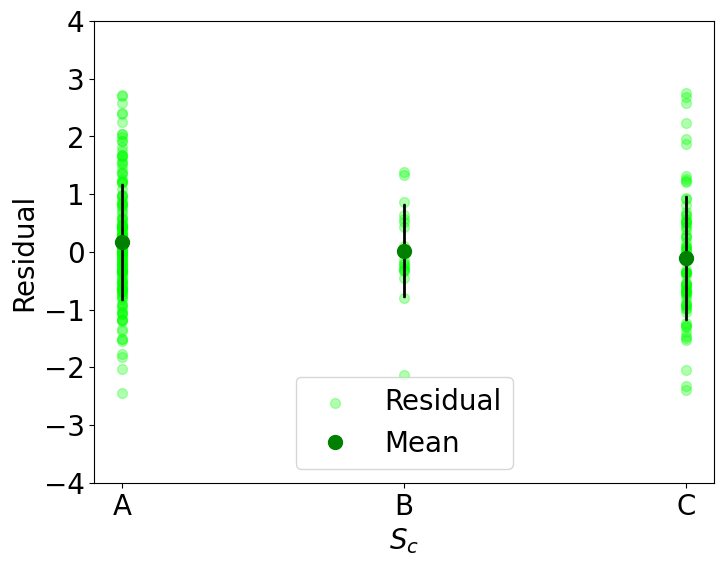

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(residuals_to_plot['vs30'], residuals_to_plot['0.01'], color='lime', marker='o', s=50, alpha=0.3, label='Residual')


means = residuals_to_plot.groupby('vs30')['0.01'].mean()
std_devs = residuals_to_plot.groupby('vs30')['0.01'].std()

for vs30_val in residuals_to_plot['vs30'].unique():
    plt.errorbar(vs30_val, means[vs30_val], yerr=std_devs[vs30_val], fmt='none', ecolor='black', capsize=1, linewidth=2)



for vs30_val in residuals_to_plot['vs30'].unique():
    plt.plot(vs30_val, means[vs30_val], 'go', markersize=10, label='Mean' if vs30_val == residuals_to_plot['vs30'].unique()[0] else '')



plt.xticks(np.arange(0, 3),labels=['A','B','C'])
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('$S_c$', fontsize=fontsize)
plt.ylabel('Residual', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(-4,4)

plt.savefig('something.png', dpi=300)

plt.show()


# Input to latent space mapping
- Mapping between X_train and encoded_data_train

# Sensitivity Analysis

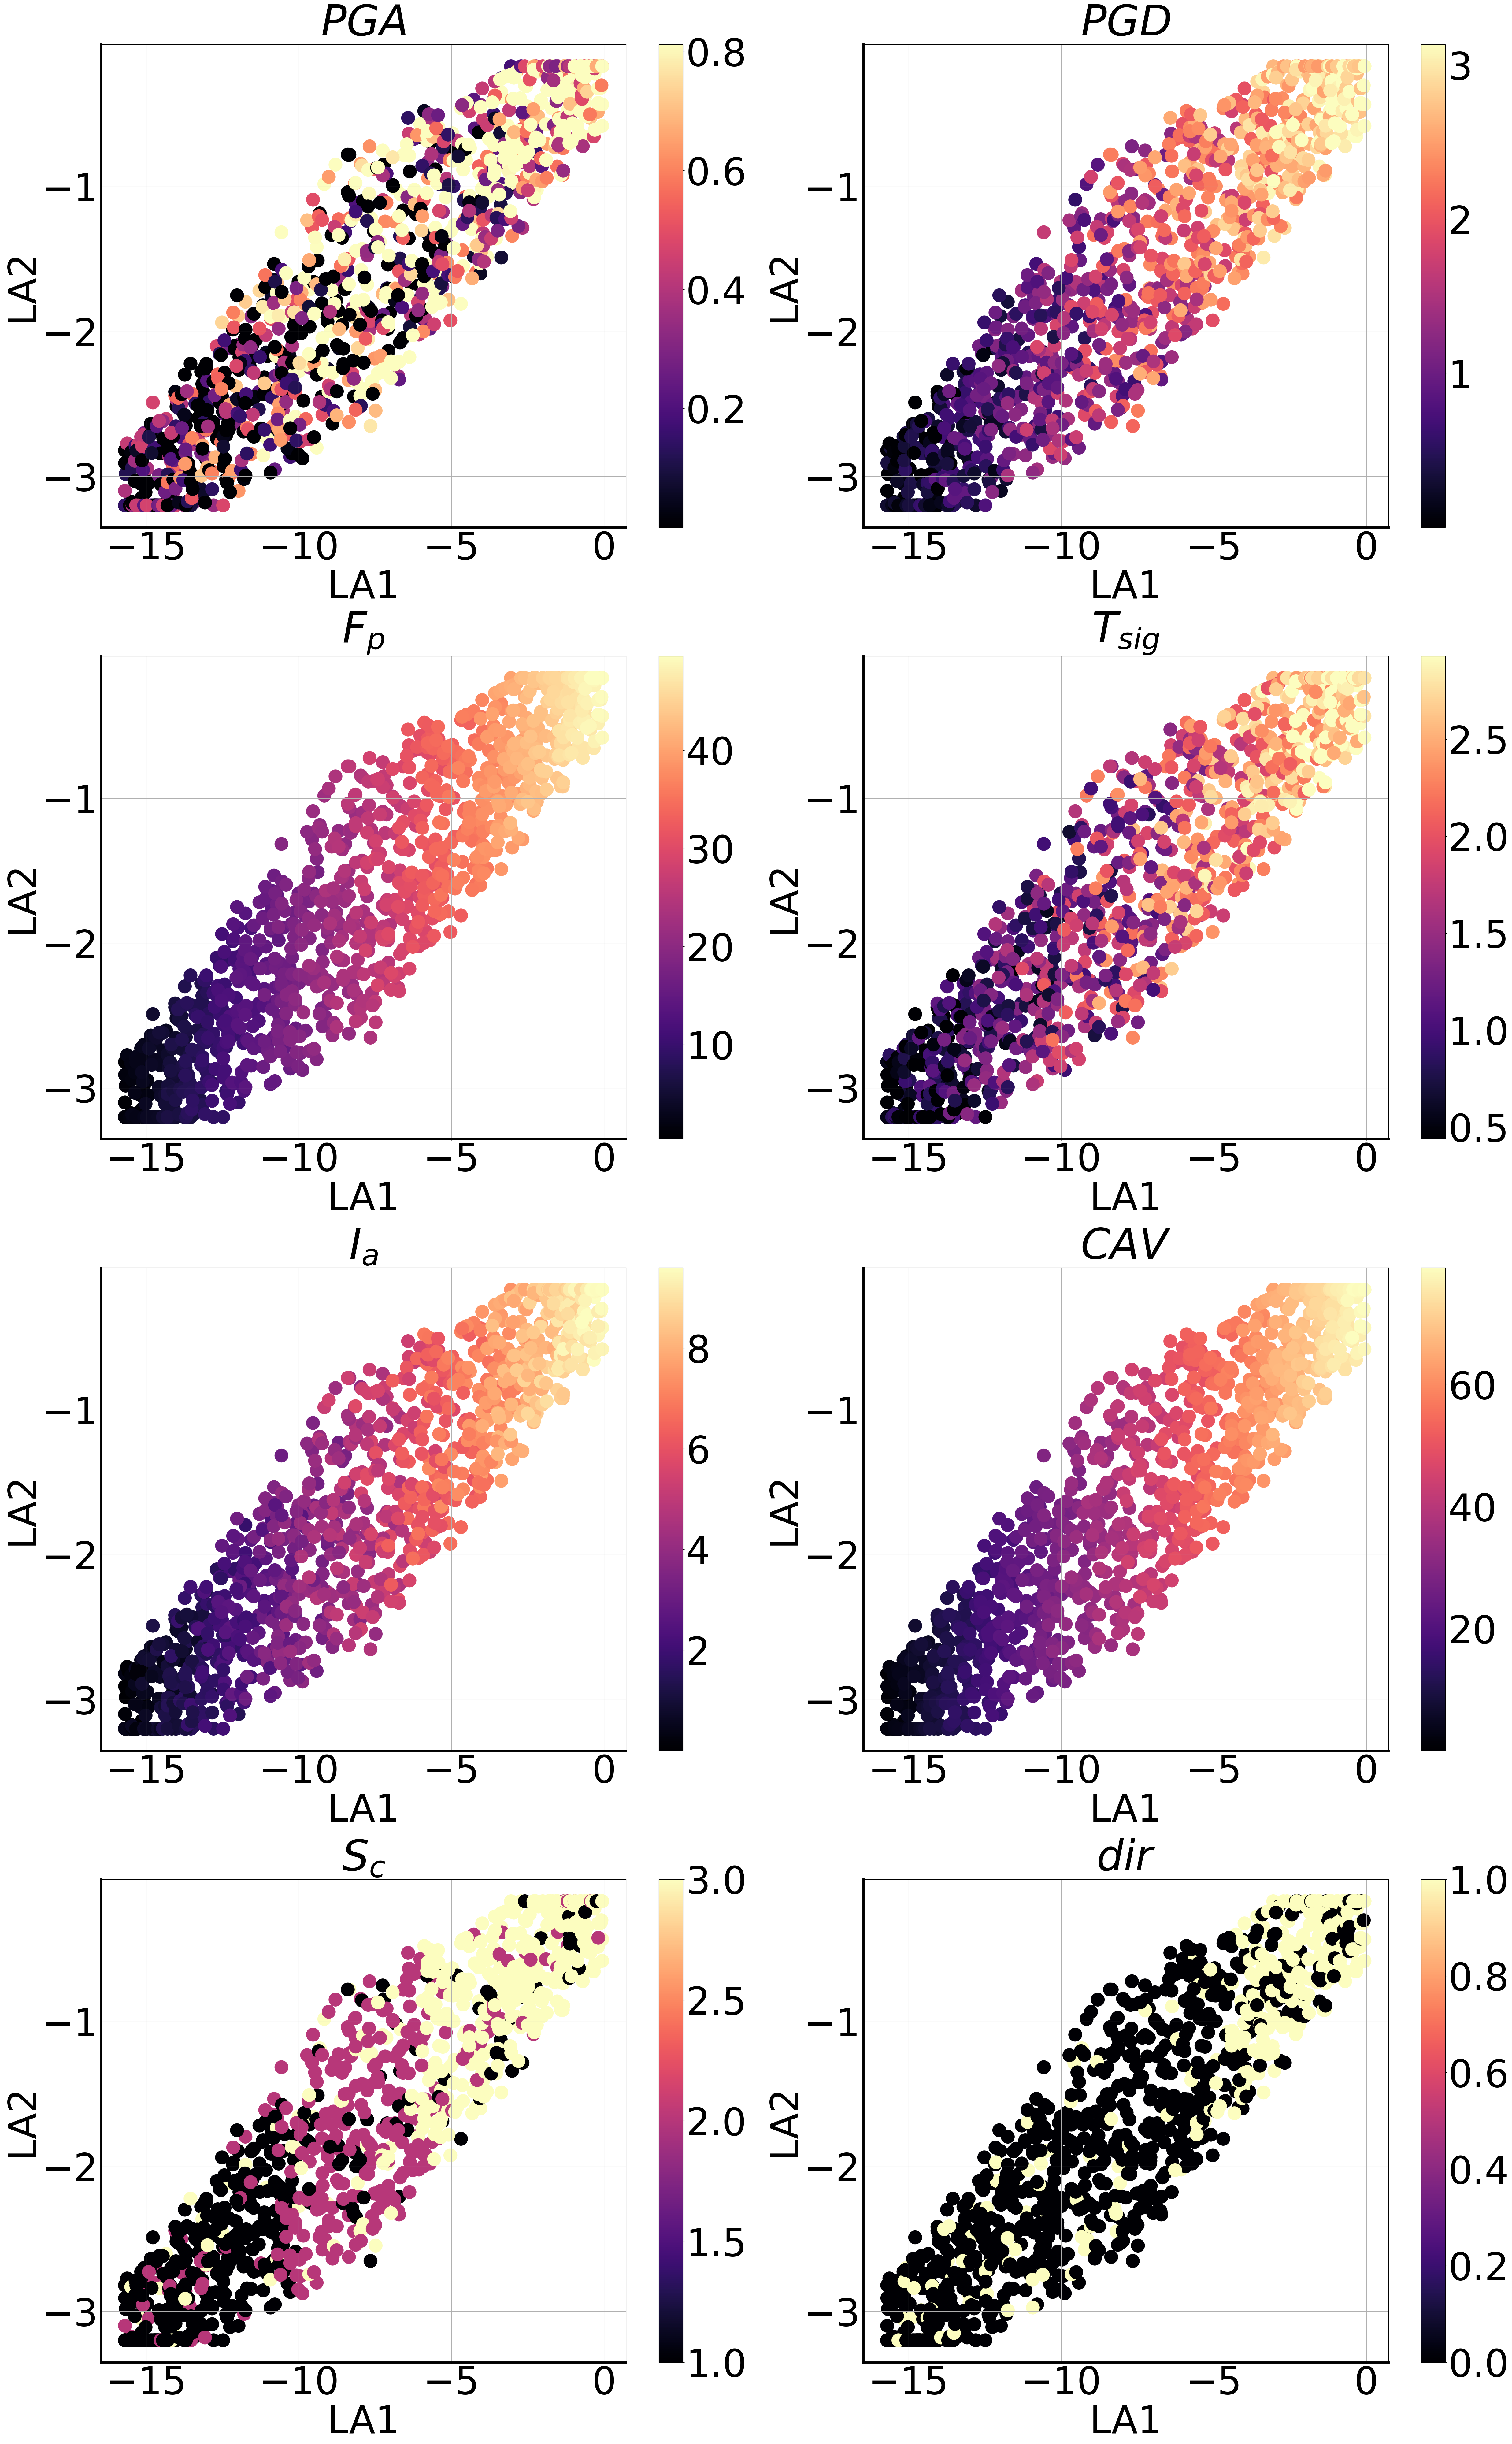

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
lr = encoded_data_train
Xr = X_train_restored

param_ranges = []
for col in range(Xr.shape[1]):
    min_val = np.min(Xr[:, col])
    max_val = np.max(Xr[:, col])
    param_ranges.append((min_val, max_val))

fig, axs = plt.subplots(4,2, figsize=(50, 80))
fontsize=90
for i, ax in enumerate(axs.flat):
    col_idx = i % Xr.shape[1]
    col_data = Xr[:, col_idx]

    scatter = ax.scatter(lr[:, 0], lr[:, 1], c=col_data, cmap='magma',s=1000)

    ax.set_xlabel('LA1',fontsize=fontsize)
    ax.set_ylabel('LA2',fontsize=fontsize)
    ax.set_title(head[col_idx],fontsize=100)
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.ax.tick_params(labelsize=fontsize)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)


plt.tight_layout()
plt.show()
plt.savefig('laip.png', dpi=300)